🧩 Cell 1 – Imports & Config Dasar

In [2]:
# Cell 1: Imports dan konfigurasi dasar

import os
import glob
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Konfigurasi umum preprocessing
GAP_THRESHOLD_TRAIN = 5       # gap > 5 frame → split segmen
MIN_TORSO_POINTS = 5          # minimal titik torso agar frame valid
MIN_SEGMENT_LEN = 10          # minimal panjang segmen agar dipakai
WINDOW_LEN = 32               # panjang window temporal
WINDOW_STRIDE = 8             # stride sliding window untuk L >= 32
N_POINTS_TARGET = 32          # jumlah titik per frame untuk PointNet
FEATURE_DIM = 4               # [x, y, z, doppler]

# Seed untuk reprodusibilitas (optional)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Using device: cpu


🧩 Cell 2 – Helper: Load CSV & Bangun Segmen

In [3]:
# Cell 2: Fungsi untuk load CSV torso & membangun segmen gait

@dataclass
class SegmentMeta:
    file_path: str
    subject_id: int
    frame_ids: List[int]  # daftar frame valid dalam segmen (urut naik)


def load_torso_csv(file_path: str) -> pd.DataFrame:
    """
    Load CSV torso hasil DBSCAN.
    Kolom yang diharapkan: timestamp, frame, x, y, z, doppler, SNR, cluster_id
    """
    df = pd.read_csv(file_path)
    # Pastikan kolom wajib ada
    required_cols = ["frame", "x", "y", "z", "doppler"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Kolom '{col}' tidak ditemukan di file {file_path}")
    return df


def build_segments_from_df(
    df: pd.DataFrame,
    gap_threshold: int = GAP_THRESHOLD_TRAIN,
    min_points: int = MIN_TORSO_POINTS,
    min_segment_len: int = MIN_SEGMENT_LEN
) -> List[List[int]]:
    """
    Dari satu DataFrame (satu trial), bangun list segmen.
    Setiap segmen = list frame_id yang valid dan kontinu (tanpa gap panjang).
    
    Aturan:
    - Frame valid: punya >= min_points titik.
    - Gap > gap_threshold frame invalid berturut-turut → segmen di-split.
    - Segmen dengan len < min_segment_len dibuang.
    """
    # Hitung jumlah titik per frame
    frame_counts = df.groupby("frame").size().to_dict()
    
    all_frames = sorted(frame_counts.keys())
    segments: List[List[int]] = []
    
    current_segment: List[int] = []
    consecutive_missing = 0
    last_frame = None
    
    # Kita iterasi frame dari min ke max berurutan, termasuk frame yang tidak ada di df
    if len(all_frames) == 0:
        return segments
    
    frame_min, frame_max = min(all_frames), max(all_frames)
    
    frame_counts_default = 0  # untuk frame yang tidak ada di df
    
    for f in range(frame_min, frame_max + 1):
        n_points = frame_counts.get(f, frame_counts_default)
        is_valid = (n_points >= min_points)
        
        if is_valid:
            # Ada torso valid
            if consecutive_missing > 0 and consecutive_missing > gap_threshold:
                # Tutup segmen sebelumnya jika cukup panjang
                if len(current_segment) >= min_segment_len:
                    segments.append(current_segment)
                current_segment = []
            consecutive_missing = 0
            current_segment.append(f)
        else:
            # frame invalid / missing
            consecutive_missing += 1
    
    # Flush segmen terakhir
    if len(current_segment) >= min_segment_len:
        segments.append(current_segment)
    
    return segments


def parse_subject_id_from_filename(file_path: str) -> str:
    """
    Dalam struktur kamu sekarang:
    E:\0.TA_Teguh\dataset2\hasil_torso_temporal\Afi\torsoT_Jalan53.csv
                                                ↑ subject = nama folder ini

    Jadi subject_id diambil dari nama folder tepat di atas file.
    """
    folder_name = os.path.basename(os.path.dirname(file_path))
    subject_id = folder_name  # contoh: 'Afi', 'Tsamara', 'Tsania'
    return subject_id



🧩 Cell 3 – Windowing & Temporal Bootstrapping

In [4]:
# Cell 3: Windowing (32 frame) + bootstrapping temporal

@dataclass
class SampleMeta:
    file_path: str
    subject_id: int       # bisa string atau int (di-encode belakangan)
    frame_ids: List[int]  # panjang tepat = WINDOW_LEN (32), sudah di-bootstrapped


def generate_samples_from_segments(
    file_path: str,
    subject_id: str,
    segments: List[List[int]],
    window_len: int = WINDOW_LEN,
    window_stride: int = WINDOW_STRIDE,
    min_len: int = MIN_SEGMENT_LEN
) -> List[SampleMeta]:
    """
    Dari daftar segmen frame_ids, hasilkan SampleMeta dengan panjang window_len.
    - Jika len(seg) >= window_len → sliding window dengan stride.
    - Jika min_len <= len(seg) < window_len → upsampling dengan replacement → 1 sample.
    """
    samples: List[SampleMeta] = []
    
    for seg in segments:
        L = len(seg)
        if L < min_len:
            continue
        
        if L >= window_len:
            # Sliding window
            start = 0
            while start + window_len <= L:
                window_frames = seg[start:start + window_len]
                samples.append(SampleMeta(
                    file_path=file_path,
                    subject_id=subject_id,
                    frame_ids=window_frames
                ))
                start += window_stride
        else:
            # 10 <= L < window_len: upsample dengan replacement
            # ambil indeks 0..L-1, sampling with replacement jadi panjang window_len
            idx_choices = np.random.choice(L, size=window_len, replace=True)
            idx_choices.sort()  # supaya urutan waktu tetap non-decreasing
            window_frames = [seg[i] for i in idx_choices]
            samples.append(SampleMeta(
                file_path=file_path,
                subject_id=subject_id,
                frame_ids=window_frames
            ))
    
    return samples


🧩 Cell 4 – Fungsionalitas: Frame → Tensor (32, 32, 4) + Augmentasi

In [5]:
# Cell 4: Dari SampleMeta → tensor (32, 32, 4) + augmentasi (opsional)

def build_frame_tensor_from_df(
    df: pd.DataFrame,
    frame_id: int,
    n_points_target: int = N_POINTS_TARGET
) -> np.ndarray:
    """
    Bangun tensor titik untuk satu frame:
    - Filter row dengan frame == frame_id
    - Pakai fitur [x, y, z, doppler]
    - Centroid-normalization
    - Bootstrapping jumlah titik ke n_points_target (up/down sampling)
    
    Output: np.ndarray shape (n_points_target, 4)
    """
    df_f = df[df["frame"] == frame_id]
    
    if len(df_f) == 0:
        raise ValueError(f"Frame {frame_id} kosong di DF, seharusnya sudah difilter saat segmen.")
    
    pts = df_f[["x", "y", "z", "doppler"]].to_numpy(dtype=np.float32)
    # centroid-normalization untuk x,y,z
    centroid = pts[:, :3].mean(axis=0, keepdims=True)
    pts[:, :3] = pts[:, :3] - centroid
    
    n = pts.shape[0]
    if n == 0:
        # keamanan ekstra
        raise ValueError(f"Tidak ada titik valid di frame {frame_id}.")
    
    if n > n_points_target:
        # random downsampling
        idx = np.random.choice(n, size=n_points_target, replace=False)
        pts = pts[idx]
    elif n < n_points_target:
        # sampling with replacement
        idx = np.random.choice(n, size=n_points_target, replace=True)
        pts = pts[idx]
    
    return pts  # (n_points_target, 4)


def augment_sample_numpy(
    sample_np: np.ndarray,
    pos_jitter_std: float = 0.01,
    rot_deg_std: float = 5.0,
    scale_std: float = 0.05,
    point_dropout_prob: float = 0.05
) -> np.ndarray:
    """
    Augmentasi pada sample shape (T=32, N=32, C=4).
    - jitter posisi (x,y,z)
    - rotasi kecil di sekitar sumbu z (yaw)
    - scaling
    - random point dropout (diisi ulang agar tetap 32)
    """
    T, N, C = sample_np.shape
    assert C == 4
    
    # 1) Jitter posisi
    noise = np.random.normal(loc=0.0, scale=pos_jitter_std, size=(T, N, 3))
    sample_np[:, :, :3] += noise
    
    # 2) Rotasi kecil di sekitar z
    theta = np.deg2rad(np.random.normal(loc=0.0, scale=rot_deg_std))
    cos_t, sin_t = math.cos(theta), math.sin(theta)
    rot_mat = np.array([[cos_t, -sin_t],
                        [sin_t,  cos_t]], dtype=np.float32)
    # apply ke (x,y)
    xy = sample_np[:, :, :2].reshape(-1, 2) @ rot_mat.T
    sample_np[:, :, :2] = xy.reshape(T, N, 2)
    
    # 3) Scaling
    scale = 1.0 + np.random.normal(loc=0.0, scale=scale_std)
    sample_np[:, :, :3] *= scale
    
    # 4) Point dropout
    # Untuk tiap frame, drop beberapa titik secara random dan isi lagi dengan sampling ulang
    for t in range(T):
        if np.random.rand() < point_dropout_prob:
            # tentukan berapa titik yang di-drop (mis. 10–30% dari N)
            drop_ratio = np.clip(np.random.uniform(0.1, 0.3), 0.0, 1.0)
            n_drop = int(N * drop_ratio)
            if n_drop <= 0:
                continue
            keep_n = N - n_drop
            idx_keep = np.random.choice(N, size=keep_n, replace=False)
            kept = sample_np[t, idx_keep, :]
            # isi kembali ke N lewat sampling with replacement
            idx_resample = np.random.choice(keep_n, size=N, replace=True)
            sample_np[t] = kept[idx_resample]
    
    return sample_np


def build_sample_tensor(
    sample_meta: SampleMeta,
    df_cache: Dict[str, pd.DataFrame],
    augment: bool = False
) -> torch.Tensor:
    """
    Dari SampleMeta + cache df, bangun tensor torch shape (T=32, N=32, C=4).
    augment=True hanya untuk train.
    """
    file_path = sample_meta.file_path
    if file_path in df_cache:
        df = df_cache[file_path]
    else:
        df = load_torso_csv(file_path)
        df_cache[file_path] = df  # cache
    
    frame_ids = sample_meta.frame_ids
    assert len(frame_ids) == WINDOW_LEN
    
    frames_np = []
    for f in frame_ids:
        frame_pts = build_frame_tensor_from_df(df, f, n_points_target=N_POINTS_TARGET)
        frames_np.append(frame_pts)  # (N,4)
    
    sample_np = np.stack(frames_np, axis=0)  # (T, N, 4)
    
    if augment:
        sample_np = augment_sample_numpy(sample_np)
    
    sample_tensor = torch.from_numpy(sample_np).float()  # (T, N, 4)
    return sample_tensor


🧩 Cell 5 – Dataset Class & Split Train/Val/Test

In [6]:
# Cell 5: Dataset Gait + split train/val/test

class GaitDataset(Dataset):
    def __init__(
        self,
        samples: List[SampleMeta],
        subject_to_idx: Dict[str, int],
        split: str = "train"
    ):
        self.samples = samples
        self.subject_to_idx = subject_to_idx
        self.split = split
        self.df_cache: Dict[str, pd.DataFrame] = {}
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx: int):
        meta = self.samples[idx]
        label = self.subject_to_idx[meta.subject_id]
        augment = (self.split == "train")
        x = build_sample_tensor(meta, self.df_cache, augment=augment)   # (T,N,C)
        # Model nanti butuh shape (B,T,N,C) → diubah di DataLoader collate atau di model
        return x, label


# def build_samples_from_root(root_dir: str) -> Tuple[List[SampleMeta], Dict[str, int]]:
#     """
#     root_dir: folder berisi file-file CSV torso.
#     - Deteksi semua *.csv
#     - Parse subject_id dari nama file
#     - Build segments + samples
#     - Kembalikan list SampleMeta dan mapping subject_to_idx
#     """
#     csv_files = sorted(glob.glob(os.path.join(root_dir, "*.csv")))
#     print(f"Found {len(csv_files)} CSV files in {root_dir}")
    
#     all_samples: List[SampleMeta] = []
#     all_subject_ids: List[str] = []
    
#     for fp in csv_files:
#         subject_id = parse_subject_id_from_filename(fp)
#         all_subject_ids.append(subject_id)
        
#         df = load_torso_csv(fp)
#         segments = build_segments_from_df(
#             df,
#             gap_threshold=GAP_THRESHOLD_TRAIN,
#             min_points=MIN_TORSO_POINTS,
#             min_segment_len=MIN_SEGMENT_LEN
#         )
#         samples = generate_samples_from_segments(
#             file_path=fp,
#             subject_id=subject_id,
#             segments=segments,
#             window_len=WINDOW_LEN,
#             window_stride=WINDOW_STRIDE,
#             min_len=MIN_SEGMENT_LEN
#         )
#         all_samples.extend(samples)
#         print(f"{os.path.basename(fp)} → {len(segments)} segments → {len(samples)} samples")
    
#     # Unique subject_id
#     uniq_subjects = sorted(list(set(all_subject_ids)))
#     subject_to_idx = {sid: i for i, sid in enumerate(uniq_subjects)}
#     print("Subjects:", subject_to_idx)
    
#     return all_samples, subject_to_idx

def build_samples_from_root(root_dir: str) -> Tuple[List[SampleMeta], Dict[str, int]]:
    """
    root_dir: E:\0.TA_Teguh\dataset2\hasil_torso_temporal
    Struktur:
      root_dir/
        Afi/
          torsoT_Jalan1.csv
          torsoT_Jalan2.csv
          ...
        Tsamara/
          torsoT_Jalan1.csv
          ...
        Tsania/
          ...

    Kita ambil semua file CSV dengan pola:
      root_dir\*\torsoT_Jalan*.csv
    """
    pattern = os.path.join(root_dir, "*", "torsoT_Jalan*.csv")
    csv_files = sorted(glob.glob(pattern))
    print(f"Found {len(csv_files)} CSV files in {root_dir} (recursively in subject folders)")
    
    all_samples: List[SampleMeta] = []
    all_subject_ids: List[str] = []
    
    for fp in csv_files:
        subject_id = parse_subject_id_from_filename(fp)
        all_subject_ids.append(subject_id)
        
        df = load_torso_csv(fp)
        segments = build_segments_from_df(
            df,
            gap_threshold=GAP_THRESHOLD_TRAIN,
            min_points=MIN_TORSO_POINTS,
            min_segment_len=MIN_SEGMENT_LEN
        )
        samples = generate_samples_from_segments(
            file_path=fp,
            subject_id=subject_id,
            segments=segments,
            window_len=WINDOW_LEN,
            window_stride=WINDOW_STRIDE,
            min_len=MIN_SEGMENT_LEN
        )
        all_samples.extend(samples)
        print(f"{subject_id} | {os.path.basename(fp)} → {len(segments)} segments → {len(samples)} samples")
    
    uniq_subjects = sorted(list(set(all_subject_ids)))
    subject_to_idx = {sid: i for i, sid in enumerate(uniq_subjects)}
    print("Subjects:", subject_to_idx)
    
    return all_samples, subject_to_idx

def split_samples_train_val_test(
    samples: List[SampleMeta],
    test_size: float = 0.2,
    val_size: float = 0.2
) -> Tuple[List[SampleMeta], List[SampleMeta], List[SampleMeta]]:
    """
    Split dataset di level SAMPLE, stratified by subject_id.
    (Kalau nanti mau LOSO per subject, bisa diubah di sini.)
    """
    labels = [s.subject_id for s in samples]
    
    # train+val vs test dulu
    samples_train_val, samples_test = train_test_split(
        samples,
        test_size=test_size,
        random_state=SEED,
        stratify=labels
    )
    
    labels_train_val = [s.subject_id for s in samples_train_val]
    
    # split train vs val
    val_ratio = val_size / (1.0 - test_size)
    samples_train, samples_val = train_test_split(
        samples_train_val,
        test_size=val_ratio,
        random_state=SEED,
        stratify=labels_train_val
    )
    
    print(f"Train: {len(samples_train)}, Val: {len(samples_val)}, Test: {len(samples_test)}")
    return samples_train, samples_val, samples_test


🧩 Cell 6 – Model: PointNet + Transformer

In [7]:
# Cell 6: Definisi model PointNet backbone + Transformer temporal

class PointNetBackbone(nn.Module):
    def __init__(self, in_channels: int = FEATURE_DIM, out_channels: int = 256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(128, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        """
        x: (B, N, C)  -> permute ke (B, C, N)
        output: (B, F) setelah max pooling
        """
        x = x.permute(0, 2, 1)  # (B,C,N)
        x = self.mlp(x)         # (B,F,N)
        x = torch.max(x, dim=2)[0]  # (B,F)
        return x


class GaitPointNetTransformer(nn.Module):
    def __init__(
        self,
        feature_dim: int = FEATURE_DIM,
        pointnet_out_dim: int = 256,
        transformer_dim: int = 256,
        num_heads: int = 4,
        num_layers: int = 2,
        num_classes: int = 3,
        dropout: float = 0.1
    ):
        super().__init__()
        self.pointnet = PointNetBackbone(
            in_channels=feature_dim,
            out_channels=pointnet_out_dim
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=num_heads,
            dim_feedforward=transformer_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        self.embedding_proj = nn.Linear(pointnet_out_dim, transformer_dim)
        
        # Positional encoding sederhana (learnable)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, WINDOW_LEN, transformer_dim)
        )
        
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, transformer_dim)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(transformer_dim, transformer_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(transformer_dim, num_classes)
        )
    
    def forward(self, x):
        """
        x: (B, T, N, C)
        1) PointNet per frame → (B,T,Fp)
        2) Project ke dim transformer → (B,T,D)
        3) Tambah CLS token + positional encoding
        4) Transformer → ambil output CLS → classifier
        """
        B, T, N, C = x.shape
        
        # Flatten batch+time agar bisa pakai PointNet per frame
        x_flat = x.reshape(B * T, N, C)        # (B*T, N, C)
        feat_flat = self.pointnet(x_flat)      # (B*T, Fp)
        feat = feat_flat.view(B, T, -1)        # (B,T,Fp)
        
        # Project ke dimensi transformer
        h = self.embedding_proj(feat)          # (B,T,D)
        
        # CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B,1,D)
        h = torch.cat([cls_tokens, h], dim=1)          # (B,1+T,D)
        
        # Positional embedding (untuk T saja, CLS pos 0 bisa 0 atau dimanfaatkan lain)
        pos = self.pos_embedding  # (1,T,D)
        pos = torch.cat([torch.zeros(1, 1, pos.size(-1), device=pos.device), pos], dim=1)
        h = h + pos  # broadcast ke batch
        
        # Transformer
        h = self.transformer(h)  # (B,1+T,D)
        
        # Ambil CLS output
        cls_out = h[:, 0, :]     # (B,D)
        logits = self.classifier(cls_out)
        return logits


🧩 Cell 7 – Training Loop, Eval, dan HPO Sederhana

In [8]:
# Cell 7: Training loop, evaluasi, dan HPO sederhana (manual grid search)

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for x, y in dataloader:
        x = x.to(device)  # (B,T,N,C)
        y = y.to(device)  # (B,)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    
    avg_loss = running_loss / total if total > 0 else 0.0
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc


def eval_one_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            logits = model(x)
            loss = criterion(logits, y)
            
            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            
            correct += (preds == y).sum().item()
            total += x.size(0)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    
    if total == 0:
        return 0.0, 0.0, None, None
    
    avg_loss = running_loss / total
    acc = correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    return avg_loss, acc, all_preds, all_labels


def manual_hpo(
    train_dataset,
    val_dataset,
    subject_to_idx: Dict[str, int],
    max_epochs: int = 10
):
    """
    HPO manual sederhana dengan grid kecil.
    Output: dict hyperparam terbaik + model terlatih (boleh juga hanya hyperparam).
    """
    num_classes = len(subject_to_idx)
    
    lr_list = [1e-3, 3e-4]
    batch_list = [8, 16]
    pointnet_dim_list = [128, 256]
    num_layers_list = [1, 2]
    num_heads_list = [2, 4]
    dropout_list = [0.0, 0.1, 0.2]
    
    best_val_acc = 0.0
    best_cfg = None
    
    for lr in lr_list:
        for batch_size in batch_list:
            for pn_dim in pointnet_dim_list:
                for n_layers in num_layers_list:
                    for n_heads in num_heads_list:
                        for dropout in dropout_list:
                            cfg = {
                                "lr": lr,
                                "batch_size": batch_size,
                                "pointnet_dim": pn_dim,
                                "num_layers": n_layers,
                                "num_heads": n_heads,
                                "dropout": dropout
                            }
                            print("\n=== HPO trial config:", cfg)
                            
                            train_loader = DataLoader(
                                train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0
                            )
                            val_loader = DataLoader(
                                val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0
                            )
                            
                            model = GaitPointNetTransformer(
                                feature_dim=FEATURE_DIM,
                                pointnet_out_dim=pn_dim,
                                transformer_dim=pn_dim,
                                num_heads=n_heads,
                                num_layers=n_layers,
                                num_classes=num_classes,
                                dropout=dropout
                            ).to(device)
                            
                            criterion = nn.CrossEntropyLoss()
                            optimizer = torch.optim.AdamW(
                                model.parameters(), lr=lr
                            )
                            
                            best_trial_val_acc = 0.0
                            for epoch in range(max_epochs):
                                train_loss, train_acc = train_one_epoch(
                                    model, train_loader, optimizer, criterion
                                )
                                val_loss, val_acc, _, _ = eval_one_epoch(
                                    model, val_loader, criterion
                                )
                                print(
                                    f"Epoch {epoch+1}/{max_epochs} | "
                                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
                                )
                                best_trial_val_acc = max(best_trial_val_acc, val_acc)
                            
                            if best_trial_val_acc > best_val_acc:
                                best_val_acc = best_trial_val_acc
                                best_cfg = cfg
                                print(">>> New best config:", best_cfg, "val_acc=", best_val_acc)
    
    print("\nHPO selesai. Best val_acc:", best_val_acc)
    print("Best config:", best_cfg)
    return best_cfg


🧩 Cell 8 – Main: Build Dataset, HPO, Training Final, Evaluasi

In [9]:
# Cell 8: Main script – build dataset, HPO, training final, evaluasi

# 1) SET ROOT DIR DATA TORSO KAMU DI SINI
ROOT_DIR = r"E:\0.TA_Teguh\dataset2\hasil_torso_temporal" # contoh; ganti sesuai lokasi folder CSV kamu

# 2) Build semua samples & mapping subject
all_samples, subject_to_idx = build_samples_from_root(ROOT_DIR)

# 3) Split train/val/test
samples_train, samples_val, samples_test = split_samples_train_val_test(
    all_samples,
    test_size=0.2,
    val_size=0.2
)

train_dataset = GaitDataset(samples_train, subject_to_idx, split="train")
val_dataset   = GaitDataset(samples_val,   subject_to_idx, split="val")
test_dataset  = GaitDataset(samples_test,  subject_to_idx, split="test")

# 4) Hyperparameter Optimization (bisa skip dulu kalau mau cepat)
DO_HPO = False  # set True kalau mau jalankan HPO penuh (akan lumayan lama)

if DO_HPO:
    best_cfg = manual_hpo(
        train_dataset,
        val_dataset,
        subject_to_idx,
        max_epochs=10
    )
else:
    # default config (kalau belum HPO)
    best_cfg = {
        "lr": 3e-4,
        "batch_size": 16,
        "pointnet_dim": 256,
        "num_layers": 2,
        "num_heads": 4,
        "dropout": 0.1
    }

print("\nConfig training final:", best_cfg)

# 5) Training final dengan config terbaik
num_classes = len(subject_to_idx)

model = GaitPointNetTransformer(
    feature_dim=FEATURE_DIM,
    pointnet_out_dim=best_cfg["pointnet_dim"],
    transformer_dim=best_cfg["pointnet_dim"],
    num_heads=best_cfg["num_heads"],
    num_layers=best_cfg["num_layers"],
    num_classes=num_classes,
    dropout=best_cfg["dropout"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=best_cfg["lr"])

train_loader = DataLoader(
    train_dataset,
    batch_size=best_cfg["batch_size"],
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_size=best_cfg["batch_size"],
    shuffle=False,
    num_workers=0
)

NUM_EPOCHS_FINAL = 50  # misal; bisa kamu sesuaikan
best_val_acc = 0.0
best_state_dict = None

train_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(NUM_EPOCHS_FINAL):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = eval_one_epoch(model, val_loader, criterion)
    
    train_history["train_loss"].append(train_loss)
    train_history["train_acc"].append(train_acc)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc"].append(val_acc)
    
    print(
        f"[Final] Epoch {epoch+1}/{NUM_EPOCHS_FINAL} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
    )
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

# Restore best model
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

# 6) Evaluasi di test set
test_loader = DataLoader(
    test_dataset,
    batch_size=best_cfg["batch_size"],
    shuffle=False,
    num_workers=0
)

test_loss, test_acc, test_preds, test_labels = eval_one_epoch(model, test_loader, criterion)
print("\n=== TEST RESULT ===")
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

idx_to_subject = {v: k for k, v in subject_to_idx.items()}
test_labels_subject = [idx_to_subject[i] for i in test_labels]
test_preds_subject  = [idx_to_subject[i] for i in test_preds]

print("\nClassification report per subject:")
print(classification_report(test_labels, test_preds, target_names=list(idx_to_subject.values())))

print("Confusion matrix:")
print(confusion_matrix(test_labels, test_preds))

# 7) (Optional) Simpan model & history
SAVE_MODEL_PATH = "gait_pointnet_transformer_best.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "subject_to_idx": subject_to_idx,
    "best_cfg": best_cfg,
    "train_history": train_history
}, SAVE_MODEL_PATH)

print(f"\nModel disimpan ke: {SAVE_MODEL_PATH}")


Found 216 CSV files in E:\0.TA_Teguh\dataset2\hasil_torso_temporal (recursively in subject folders)
Afi | torsoT_Jalan1.csv → 1 segments → 6 samples
Afi | torsoT_Jalan10.csv → 1 segments → 6 samples
Afi | torsoT_Jalan11.csv → 1 segments → 8 samples
Afi | torsoT_Jalan12.csv → 1 segments → 5 samples
Afi | torsoT_Jalan13.csv → 1 segments → 6 samples
Afi | torsoT_Jalan14.csv → 1 segments → 5 samples
Afi | torsoT_Jalan15.csv → 1 segments → 21 samples
Afi | torsoT_Jalan16.csv → 1 segments → 20 samples
Afi | torsoT_Jalan17.csv → 1 segments → 16 samples
Afi | torsoT_Jalan18.csv → 1 segments → 12 samples
Afi | torsoT_Jalan19.csv → 1 segments → 18 samples
Afi | torsoT_Jalan2.csv → 1 segments → 6 samples
Afi | torsoT_Jalan20.csv → 1 segments → 16 samples
Afi | torsoT_Jalan21.csv → 1 segments → 13 samples
Afi | torsoT_Jalan22.csv → 1 segments → 7 samples
Afi | torsoT_Jalan23.csv → 1 segments → 38 samples
Afi | torsoT_Jalan24.csv → 1 segments → 32 samples
Afi | torsoT_Jalan25.csv → 1 segments → 3 s

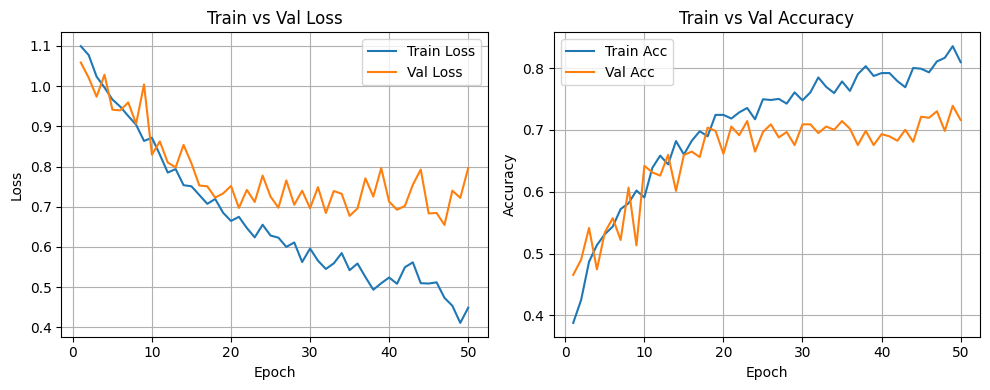

In [10]:
# Cell A: Plot train/val loss dan accuracy

import matplotlib.pyplot as plt

# Pastikan train_history sudah terisi dari proses training final (Cell 8)
epochs = range(1, len(train_history["train_loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_history["train_loss"], label="Train Loss")
plt.plot(epochs, train_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_history["train_acc"], label="Train Acc")
plt.plot(epochs, train_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


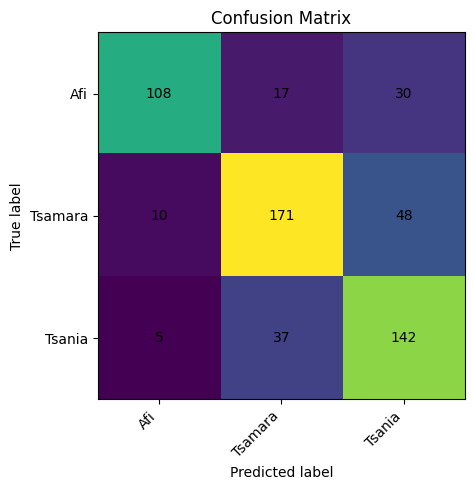

In [11]:
# Cell B: Plot confusion matrix sebagai heatmap

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Pastikan variabel test_labels dan test_preds sudah ada dari evaluasi test di Cell 8
cm = confusion_matrix(test_labels, test_preds)
labels = [idx_to_subject[i] for i in range(len(idx_to_subject))]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest")

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix")

# Tampilkan angka di setiap kotak
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, str(cm[i, j]),
            ha="center", va="center"
        )

fig.tight_layout()
plt.show()


In [12]:
# Cell C: Evaluasi metrik lengkap (precision, recall, F1, classification report)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# pastikan test_labels dan test_preds sudah ada
precision_macro = precision_score(test_labels, test_preds, average="macro")
recall_macro = recall_score(test_labels, test_preds, average="macro")
f1_macro = f1_score(test_labels, test_preds, average="macro")

precision_weighted = precision_score(test_labels, test_preds, average="weighted")
recall_weighted = recall_score(test_labels, test_preds, average="weighted")
f1_weighted = f1_score(test_labels, test_preds, average="weighted")

print("=== Evaluation Metrics ===")
print(f"Test Accuracy         : {np.mean(np.array(test_preds) == np.array(test_labels)):.4f}")
print(f"Precision (macro)     : {precision_macro:.4f}")
print(f"Recall (macro)        : {recall_macro:.4f}")
print(f"F1-score (macro)      : {f1_macro:.4f}")
print(f"Precision (weighted)  : {precision_weighted:.4f}")
print(f"Recall (weighted)     : {recall_weighted:.4f}")
print(f"F1-score (weighted)   : {f1_weighted:.4f}")

# Classification report per subject
labels = [idx_to_subject[i] for i in range(len(idx_to_subject))]
print("\n=== Classification Report ===")
print(classification_report(test_labels, test_preds, target_names=labels))


=== Evaluation Metrics ===
Test Accuracy         : 0.7412
Precision (macro)     : 0.7612
Recall (macro)        : 0.7384
F1-score (macro)      : 0.7444
Precision (weighted)  : 0.7551
Recall (weighted)     : 0.7412
F1-score (weighted)   : 0.7435

=== Classification Report ===
              precision    recall  f1-score   support

         Afi       0.88      0.70      0.78       155
     Tsamara       0.76      0.75      0.75       229
      Tsania       0.65      0.77      0.70       184

    accuracy                           0.74       568
   macro avg       0.76      0.74      0.74       568
weighted avg       0.76      0.74      0.74       568

